# Imports

In [55]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import time
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Turn off warning for gradients and hessians
from tensorflow.python.eager import forwardprop
import plotnine
from plotnine import *
plotnine.options.figure_size = (10, 5)
from mizani.transforms  import log_trans

# Problem Description

When computing the hessian (i.e., gradient of a gradient) of a loss function with vector input (i.e., multi-parameter optimization), instead of returning the element-wise hessian, the second gradient appears to return the row-wise sum of the hessian. For a more detailed discussion, we refer to https://github.com/tensorflow/tensorflow/issues/29064. The below code snippet illustrates the problem.

In [56]:
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[2.0, 1.0], [0, 4.0]])

with tf.GradientTape(persistent=True) as tape:
    tape.watch(a)
    c = tf.math.reduce_mean(a)
    d = tf.matmul(a, b)
    grads_c = tape.gradient(c, a)  
    grads_d = tape.gradient(d, a)  
    grads_c_d = tape.gradient([c, d], a)  

In [57]:
grads_c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.25, 0.25],
       [0.25, 0.25]], dtype=float32)>

In [58]:
grads_d

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3., 4.],
       [3., 4.]], dtype=float32)>

In [59]:
grads_c_d # = grads_c + grads_d

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.25, 4.25],
       [3.25, 4.25]], dtype=float32)>

For XGBoost and LightGBM to work properly, we need to compute correct gradients and hessians. As we show in the following, we can circumvent the problem of wrong hessians. However, these implementations are not as efficient as the original nested gradient_tape version. Hence, we trade-off accuracy vs. computational efficiency. The problem is that for Distributional Gradient Boosting Machines the issue of runtime is very pronounced, since we need to compute gradients and hessians for multiple parameters, i.e., M (=Number of Bernstein-Polynomials) + 4 parameters. Hence, if we specify M=10, we need to compute gradients and hessians for 14 parameters. While gradients are correct, the default nested tf.GradientTape() implementation returns the wrong hessians, despite being very fast. In contrast, tf.jacobian returns correct gradients and hessian, however, this is very slow. In the following, we present several different auto_grad implementations using a simulated Gaussian example, where gradients and hessians are computed for location and scale parameter. All runtimes are measured in seconds.

# Gaussian Example: compute gradients and hessians for location and scale

### Generate Data Samples

In [60]:
tf.random.set_seed(123)
np.random.seed(123)

n_samples = 1000
n_param = 2
x = np.random.uniform(size=n_samples)
location = np.random.normal(10, 0.1, size=n_samples)
scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)
y = norm.rvs(loc=location, scale=scale)

# Convert response to tensor
dtype = tf.float32
target = tf.Variable(y, dtype=dtype)

# Generate random location and scale parameters that mimic the estimated parameters
params_predt = tf.Variable(np.random.randn(n_samples*n_param).reshape(-1,n_param), dtype=dtype) 

### Plot Data

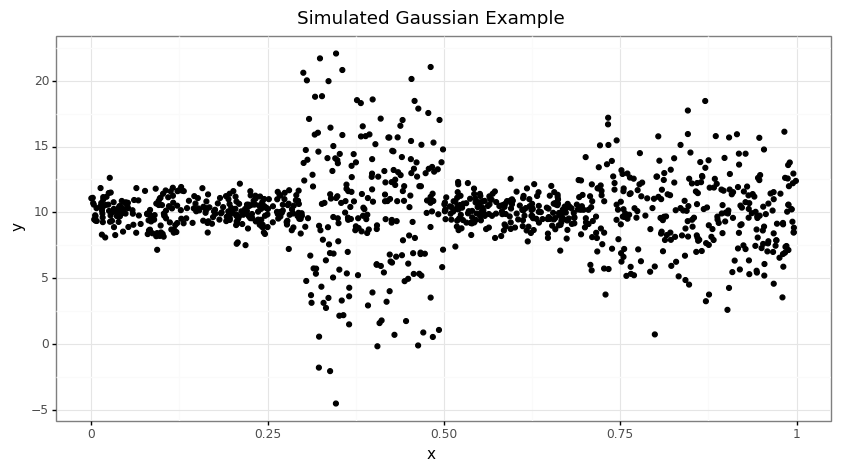

<ggplot: (184815963203)>

In [61]:
data_df = pd.DataFrame.from_dict({"x": x,
                                  "y": y,
                                  "location": location,
                                  "scale": scale
                                 })

(ggplot(data_df,
        aes(x="x",
            y="y"))  + 
 geom_point() + 
 theme_bw() + 
 labs(title="Simulated Gaussian Example")
)

# Define custom density to mimic multi-parameter gradient and hessian derivation

In [62]:
def custom_normal_density(params):
    loc, scale = params[:,0], params[:,1]
    dens = tfp.distributions.Normal(loc=loc, scale=scale)
    return dens

# Compute derivatives for all distributional parameters

In the following, we create several loops over each example to get a more stable estimate of the runtimes.  

### Select number of runs

In [63]:
n_runs = 100

### Example 1: Wrong Hessian, but fast

In [64]:
example_1=[]

for i in range(n_runs):

    start = time.perf_counter()    

    with tf.GradientTape() as outer_tape:
        with tf.GradientTape() as inner_tape:
            custom_dens = custom_normal_density(params_predt)
            nll = -tf.math.reduce_sum(custom_dens.log_prob(target)) 
        grad = inner_tape.gradient(nll, params_predt)
    hess = outer_tape.gradient(grad, params_predt)

    end = time.perf_counter()   
    example_1.append(end-start)

example_1 = pd.DataFrame.from_dict({"Example": 1,
                                    "Runtime": example_1
                                   })

print(f"Average Runtime Example 1: {example_1.Runtime.mean()}")

Average Runtime Example 1: 0.004849616999999284


In [65]:
tf.concat(grad,axis=1).numpy()[0:10,:]

array([[-1.5733637e+01, -1.9499643e+02],
       [-3.3781655e+00,  2.0925194e+01],
       [-3.1692698e+01,  5.9354358e+02],
       [-1.8842628e+01,  2.7015143e+02],
       [-1.1348611e+01,  1.4341882e+02],
       [-2.3199885e+00, -6.9341431e+00],
       [-2.5939424e+00, -1.0697381e+01],
       [-7.5451434e+02, -6.2982734e+04],
       [-4.4577359e+02, -2.9477801e+04],
       [-4.7068286e+00,  3.4875740e+01]], dtype=float32)

In [66]:
tf.concat(hess,axis=1).numpy()[0:10,:]

array([[ 4.1281830e+01,  7.8074188e+02],
       [-3.3105094e+00,  3.0359764e+01],
       [-1.0411265e+02,  2.9034734e+03],
       [-4.7578331e+01,  1.0141344e+03],
       [-1.9459721e+01,  3.6532022e+02],
       [ 3.7658520e+00,  1.8919937e+01],
       [ 3.4459512e+00,  2.2921595e+01],
       [ 1.3719613e+04,  1.7214319e+06],
       [ 6.0540967e+03,  6.0210562e+05],
       [-5.4852881e+00,  6.0198505e+01]], dtype=float32)

### Example 2: Correct Hessian, but slow

In [82]:
example_2=[]

for i in range(n_runs):

    start = time.perf_counter()   

    with tf.GradientTape(persistent=True) as outer_tape:
        with tf.GradientTape() as inner_tape:
            custom_dens = custom_normal_density(params_predt)
            nll = -tf.math.reduce_sum(custom_dens.log_prob(target)) 
        grad = inner_tape.gradient(nll, params_predt)
    hess = outer_tape.jacobian(grad, params_predt, experimental_use_pfor=False)

    params_deriv_dim = tf.reduce_prod(params_predt.shape)
    hess = tf.reshape(hess, [params_deriv_dim, params_deriv_dim])
    hess = np.diagonal(hess.numpy()).reshape(-1, params_predt.shape[1])

    end = time.perf_counter()    
    example_2.append(end-start)

example_2 = pd.DataFrame.from_dict({"Example": 2,
                                    "Runtime": example_2
                                   })

print(f"Average Runtime Example 2: {example_2.Runtime.mean()}")

Average Runtime Example 2: 6.0682501


In [68]:
tf.concat(grad,axis=1).numpy()[0:10,:]

array([[-1.5733637e+01, -1.9499643e+02],
       [-3.3781655e+00,  2.0925194e+01],
       [-3.1692698e+01,  5.9354358e+02],
       [-1.8842628e+01,  2.7015143e+02],
       [-1.1348611e+01,  1.4341882e+02],
       [-2.3199885e+00, -6.9341431e+00],
       [-2.5939424e+00, -1.0697381e+01],
       [-7.5451434e+02, -6.2982734e+04],
       [-4.4577359e+02, -2.9477801e+04],
       [-4.7068286e+00,  3.4875740e+01]], dtype=float32)

In [69]:
tf.concat(hess,axis=1).numpy()[0:10,:]

array([[ 4.1281830e+01,  7.8074188e+02],
       [-3.3105094e+00,  3.0359764e+01],
       [-1.0411265e+02,  2.9034734e+03],
       [-4.7578331e+01,  1.0141344e+03],
       [-1.9459721e+01,  3.6532022e+02],
       [ 3.7658520e+00,  1.8919937e+01],
       [ 3.4459512e+00,  2.2921595e+01],
       [ 1.3719613e+04,  1.7214319e+06],
       [ 6.0540967e+03,  6.0210562e+05],
       [-5.4852881e+00,  6.0198505e+01]], dtype=float32)

### Example 3: Current Implementation, medium speed

This example is currently implemented in the paper. It 
- gives the correct hessian
- is faster than tf.jacobian
- is slower than using nested gradient_tapes, where runtime increases with number of parameters

The gradients are calculated within the usual gradient_tape. However, we use a list of parameters so that we can loop over the list elements to compute the hessian. Even though this example is competitive to the nested gradient of example 1 given the toy example in this notebook, runtime increases considerably with the sample size and the number of distributional parameters to estimate.

In [70]:
param_list = [tf.reshape(params_predt[:,i],[-1,1]) for i in range(n_param)]

example_3=[]

for i in range(n_runs):

    start = time.perf_counter()    

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(param_list)
        custom_dens = custom_normal_density(tf.concat(param_list, axis=1))
        nll = -tf.math.reduce_sum(custom_dens.log_prob(target))
        grad = tape.gradient(nll, param_list)
    hess = []
    i=0
    for x in grad:
        hess.append(tape.gradient(x, param_list)[i])
        i+=1
    del tape    

    end = time.perf_counter()    
    example_3.append(end-start)

example_3 = pd.DataFrame.from_dict({"Example": 3,
                                    "Runtime": example_3
                                   })

print(f"Average Runtime Example 3: {example_3.Runtime.mean()}")

Average Runtime Example 3: 0.007878703999999886


In [71]:
tf.concat(grad,axis=1).numpy()[0:10,:]

array([[-1.5733637e+01, -1.9499643e+02],
       [-3.3781655e+00,  2.0925194e+01],
       [-3.1692698e+01,  5.9354358e+02],
       [-1.8842628e+01,  2.7015143e+02],
       [-1.1348611e+01,  1.4341882e+02],
       [-2.3199885e+00, -6.9341431e+00],
       [-2.5939424e+00, -1.0697381e+01],
       [-7.5451434e+02, -6.2982734e+04],
       [-4.4577359e+02, -2.9477801e+04],
       [-4.7068286e+00,  3.4875740e+01]], dtype=float32)

In [72]:
tf.concat(hess,axis=1).numpy()[0:10,:]

array([[1.5909729e+00, 7.4105096e+02],
       [2.8286797e-01, 3.3953140e+01],
       [2.8475130e+00, 3.0104333e+03],
       [1.7106313e+00, 1.0634235e+03],
       [7.9647160e-01, 3.8557645e+02],
       [4.9647591e-01, 1.5650561e+01],
       [3.5498360e-01, 1.9830626e+01],
       [8.1677467e+01, 1.7077939e+06],
       [4.5422249e+01, 5.9609694e+05],
       [3.8945886e-01, 6.6073242e+01]], dtype=float32)

### Example 4

This example
- gives the correct hessian
- is faster than tf.jacobian
- is slower than using nested gradient_tapes

Gradients and hessian are calculated each within a loop, where we use a list of parameters so that we can loop over the list elements.

In [73]:
example_4=[]

for j in range(n_runs):
    
    start = time.perf_counter() 
    grad_list=[]
    hess_list=[]

    for i in range(len(param_list)):

        with tf.GradientTape() as outer_tape:
            outer_tape.watch(param_list)
            with tf.GradientTape() as inner_tape:
                inner_tape.watch(param_list)
                custom_dens = custom_normal_density(tf.concat(param_list, axis=1))
                nll = -tf.math.reduce_sum(custom_dens.log_prob(target))
                grad = inner_tape.gradient(nll, param_list[i])
            grad_list.append(grad)
        hess = outer_tape.gradient(grad, param_list[i])
        hess_list.append(hess)

    end = time.perf_counter()    

    example_4.append(end-start)

example_4 = pd.DataFrame.from_dict({"Example": 4,
                                    "Runtime": example_4
                                   })

print(f"Average Runtime Example 4: {example_4.Runtime.mean()}")

Average Runtime Example 4: 0.009992885999999573


In [74]:
tf.concat(grad_list,axis=1).numpy()[0:10,:]

array([[-1.5733637e+01, -1.9499643e+02],
       [-3.3781655e+00,  2.0925194e+01],
       [-3.1692698e+01,  5.9354358e+02],
       [-1.8842628e+01,  2.7015143e+02],
       [-1.1348611e+01,  1.4341882e+02],
       [-2.3199885e+00, -6.9341431e+00],
       [-2.5939424e+00, -1.0697381e+01],
       [-7.5451434e+02, -6.2982734e+04],
       [-4.4577359e+02, -2.9477801e+04],
       [-4.7068286e+00,  3.4875740e+01]], dtype=float32)

In [75]:
tf.concat(hess_list,axis=1).numpy()[0:10,:]

array([[1.5909729e+00, 7.4105096e+02],
       [2.8286797e-01, 3.3953140e+01],
       [2.8475130e+00, 3.0104333e+03],
       [1.7106313e+00, 1.0634235e+03],
       [7.9647160e-01, 3.8557645e+02],
       [4.9647591e-01, 1.5650561e+01],
       [3.5498360e-01, 1.9830626e+01],
       [8.1677467e+01, 1.7077939e+06],
       [4.5422249e+01, 5.9609694e+05],
       [3.8945886e-01, 6.6073242e+01]], dtype=float32)

### Example 5: Slow and wrong hessian

In [76]:
example_5=[]

for i in range(n_runs):

    start = time.perf_counter()   

    vector = [tf.ones_like(v) for v in param_list]

    with forwardprop.ForwardAccumulator(param_list, vector) as acc:
        with tf.GradientTape() as grad_tape:
            grad_tape.watch(param_list)
            custom_dens = custom_normal_density(tf.concat(param_list, axis=1))
            nll = -tf.math.reduce_sum(custom_dens.log_prob(target))
        grad = grad_tape.gradient(nll, param_list)
    hess = acc.jvp(grad)

    end = time.perf_counter()  
    example_5.append(end-start)
    
example_5 = pd.DataFrame.from_dict({"Example": 5,
                                    "Runtime": example_5
                                   })

print(f"Average Runtime Example 5: {example_5.Runtime.mean()}")

Average Runtime Example 5: 0.024926647999999288


In [77]:
tf.concat(grad,axis=1).numpy()[0:10,:]

array([[-1.5733637e+01, -1.9499643e+02],
       [-3.3781655e+00,  2.0925194e+01],
       [-3.1692698e+01,  5.9354358e+02],
       [-1.8842628e+01,  2.7015143e+02],
       [-1.1348611e+01,  1.4341882e+02],
       [-2.3199885e+00, -6.9341431e+00],
       [-2.5939424e+00, -1.0697381e+01],
       [-7.5451434e+02, -6.2982734e+04],
       [-4.4577359e+02, -2.9477801e+04],
       [-4.7068286e+00,  3.4875740e+01]], dtype=float32)

In [78]:
tf.concat(hess,axis=1).numpy()[0:10,:]

array([[ 4.1281830e+01,  7.8074188e+02],
       [-3.3105094e+00,  3.0359764e+01],
       [-1.0411265e+02,  2.9034734e+03],
       [-4.7578331e+01,  1.0141344e+03],
       [-1.9459721e+01,  3.6532025e+02],
       [ 3.7658520e+00,  1.8919937e+01],
       [ 3.4459512e+00,  2.2921593e+01],
       [ 1.3719613e+04,  1.7214319e+06],
       [ 6.0540967e+03,  6.0210556e+05],
       [-5.4852881e+00,  6.0198502e+01]], dtype=float32)

More examples of how to "efficiently calculate the hessian vector product can be found here: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/benchmarks/resnet50/hvp_test.py. However, none of them computes the correct hessian.

# Runtime Plots

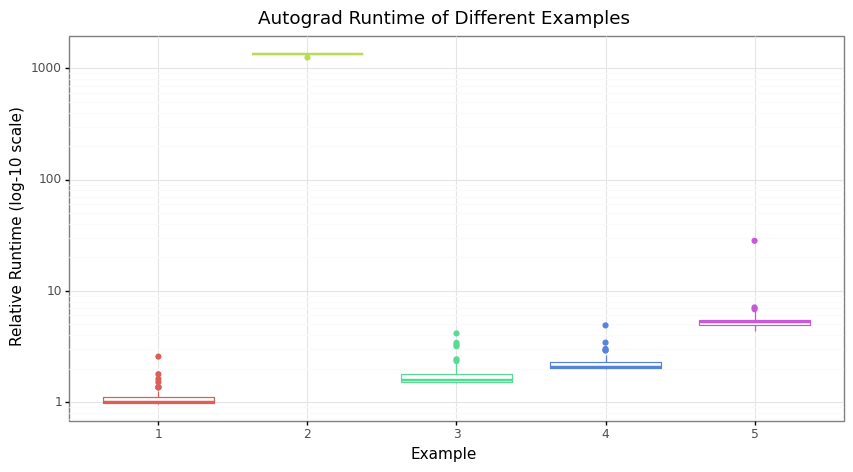

<ggplot: (184687394082)>

In [79]:
plot_df = pd.concat([example_1, example_2, example_3, example_4, example_5], ignore_index=True)
plot_df["Example"] = pd.Categorical(plot_df["Example"])
plot_df["Runtime_Relative"] = plot_df["Runtime"] / example_1["Runtime"].median() # normalize so that first example is reference 

(ggplot(plot_df,
        aes(x="Example",
            y="Runtime_Relative",
            color="Example")) + 
 geom_boxplot() + 
 scale_y_continuous(trans=log_trans(base=10)) + 
 theme_bw() + 
 theme(legend_position = "none") + 
 labs(title="Autograd Runtime of Different Examples",
      y = "Relative Runtime (log-10 scale)")
)

In [80]:
plot_df.groupby("Example")["Runtime_Relative"].agg("median").reset_index()

,Example,Runtime_Relative
0,1,1.000000
1,2,1352.414321
2,3,1.590929
3,4,2.052943
4,5,5.204833


# More efficient workaround

The community is kindly asked and encouraged to provide a more efficient workaround. 

In [81]:
# your example here